In [173]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gpytorch.priors import GammaPrior
import torch
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import optuna
import gpytorch


In [375]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 1e0), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [419]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [400]:

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl','PTAU_bl', 'TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 3) (109, 3)


In [401]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [358]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    scheduler_type = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealingLR"])
    lengthscale = trial.suggest_float("lengthscale", 1e-3, 1e1, log=True)

    num_tasks = 3
    noise_prior = GammaPrior(concentration=1.1, rate=0.05)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)

    class TrialMultitaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, num_tasks):
            super(TrialMultitaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.MultitaskMean(
                gpytorch.means.ZeroMean(), num_tasks=num_tasks
            )
            self.covar_module = gpytorch.kernels.MultitaskKernel(
                gpytorch.kernels.RQKernel(lengthscale=lengthscale), num_tasks=num_tasks, rank=1
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    model = TrialMultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    model.to(device)

    # Configure optimizer
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9, maximize=True)

    # Configure scheduler
    if scheduler_type == "ReduceLROnPlateau":
        factor = trial.suggest_float("factor", 0.1, 0.9)
        patience = trial.suggest_int("patience", 3, 20)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=factor, patience=patience, threshold=1e-4)
    elif scheduler_type == "StepLR":
        step_size = trial.suggest_int("step_size", 5, 50)
        gamma = trial.suggest_float("gamma", 0.1, 0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        t_max = trial.suggest_int("t_max", 5, 50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    # Loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    initial_likelihood = mll(model(X_train), y_train)
    while initial_likelihood < -1.55:
        model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
        model.to(device)
        initial_likelihood = mll(model(X_train), y_train)
    print(f'Model finially intialized with likelihood: {initial_likelihood}')

    # Train the model
    model.train()
    likelihood.train()

    num_iter = 500  # You could also make this a hyperparameter

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = mll(output, y_train)
        loss.backward()
        optimizer.step()

        # Handle different scheduler types
        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(mll(output, y_train))  # Pass validation metric
        else:
            scheduler.step()

        # Report intermediate values for pruning
        if i % 20 == 0:
            trial.report(-loss.item(), i)

            # Enable pruning of unpromising trials
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Evaluate on test set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(X_test)
        mean = preds.mean

    y_true_np = y_test.cpu().numpy()
    y_pred_np = mean.cpu().numpy()

    # Calculate mean R² across all targets
    r2_values = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(num_tasks)]
    mean_r2 = np.mean(r2_values)

    return mean_r2  # Return metric to maximize

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  R² Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-02 16:18:09,164] A new study created in memory with name: no-name-5cea1ea6-9b10-4905-b117-ba3d807e3459
[W 2025-07-02 16:18:09,181] Trial 0 failed with parameters: {'lr': 0.0011463982176713142, 'weight_decay': 4.575577869584832e-05, 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingLR', 'lengthscale': 0.015343777952437566, 't_max': 16} because of the following error: RuntimeError('Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument other in method wrapper_CUDA__equal)').
Traceback (most recent call last):
  File "C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_26204\989518133.py", line 57, in objective
    initial_likelihood = mll(model(X_train), y_train)
                             ^^^^^^^^^^^

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument other in method wrapper_CUDA__equal)

In [408]:
device = 'cuda'
torch.manual_seed(42)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 3
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)
# likelihood.noise = 0.5
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
model.to(device)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -1.55:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    model.to(device)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.02, weight_decay = 1e-5, maximize=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.010873204579394679, weight_decay = 0.0009152256293915124, maximize=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, maximize=True)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600], gamma=10)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold=1e-4)
# scheduler = IncreaseLROnPlateau(optimizer, mode='max', patience=3, threshold=1e-4, factor=2.0, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.264146097094465, patience=14, threshold=1e-4)

training_loss = []
test_losses = []


Model finially intialized with likelihood: -1.50616455078125


In [409]:
num_iter = 500
model.to(device)
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    mean = output.mean
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())

    # Break the loop if loss does not decrease significantly over the last 3 epochs
    if i > 3 and abs(training_loss[-1] - training_loss[-2]) < 1e-5 and abs(training_loss[-2] - training_loss[-3]) < 1e-5:
        print(f"Early stopping at iteration {i} with loss {loss.item()}")
        break

    optimizer.step()
    # scheduler.step(loss.item())

    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())

    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/500 - Loss: -1.506
Iter 2/500 - Loss: -1.463
Iter 3/500 - Loss: -1.420
Iter 4/500 - Loss: -1.381
Iter 5/500 - Loss: -1.346
Iter 6/500 - Loss: -1.317
Iter 7/500 - Loss: -1.291
Iter 8/500 - Loss: -1.268
Iter 9/500 - Loss: -1.244
Iter 10/500 - Loss: -1.217
Iter 11/500 - Loss: -1.186
Iter 12/500 - Loss: -1.154
Iter 13/500 - Loss: -1.121
Iter 14/500 - Loss: -1.090
Iter 15/500 - Loss: -1.060
Iter 16/500 - Loss: -1.033
Iter 17/500 - Loss: -1.005
Iter 18/500 - Loss: -0.978
Iter 19/500 - Loss: -0.951
Iter 20/500 - Loss: -0.925
Iter 21/500 - Loss: -0.899
Iter 22/500 - Loss: -0.877
Iter 23/500 - Loss: -0.857
Iter 24/500 - Loss: -0.840
Iter 25/500 - Loss: -0.824
Iter 26/500 - Loss: -0.808
Iter 27/500 - Loss: -0.790
Iter 28/500 - Loss: -0.773
Iter 29/500 - Loss: -0.757
Iter 30/500 - Loss: -0.742
Iter 31/500 - Loss: -0.727
Iter 32/500 - Loss: -0.712
Iter 33/500 - Loss: -0.699
Iter 34/500 - Loss: -0.686
Iter 35/500 - Loss: -0.672
Iter 36/500 - Loss: -0.660
Iter 37/500 - Loss: -0.648
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

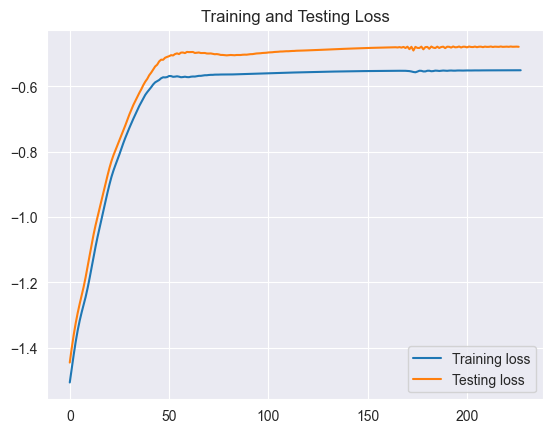

In [410]:
plt.title('Training and Testing Loss')
plt.plot(training_loss, label='Training loss')
plt.plot(test_losses,label='Testing loss')
plt.legend()
plt.show()

In [411]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')

Parameter name: likelihood.task_noise_covar_factor         value = [[-0.3657969534397125], [-0.5786858797073364], [-0.6489266753196716]]
Parameter name: likelihood.raw_noise                       value = [-4.933021545410156]
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.1429399698972702], [-0.9669691920280457], [-0.95440274477005]]
Parameter name: covar_module.task_covar_module.raw_var     value = [0.4928331971168518, -5.082424640655518, -4.260316848754883]
Parameter name: covar_module.data_covar_module.raw_lengthscale value = [[6.897841453552246]]
Parameter name: covar_module.data_covar_module.raw_alpha   value = [-1.7688652276992798]


In [412]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Target 1: MSE = 0.0976, RMSE = 0.3124, R2 = 0.9029
Target 2: MSE = 0.2353, RMSE = 0.4850, R2 = 0.7623
Target 3: MSE = 0.3136, RMSE = 0.5600, R2 = 0.6865


Target 1: MSE = 0.3580, RMSE = 0.5983, R2 = 0.6341
Target 2: MSE = 0.5362, RMSE = 0.7323, R2 = 0.4838
Target 3: MSE = 0.5748, RMSE = 0.7581, R2 = 0.4226


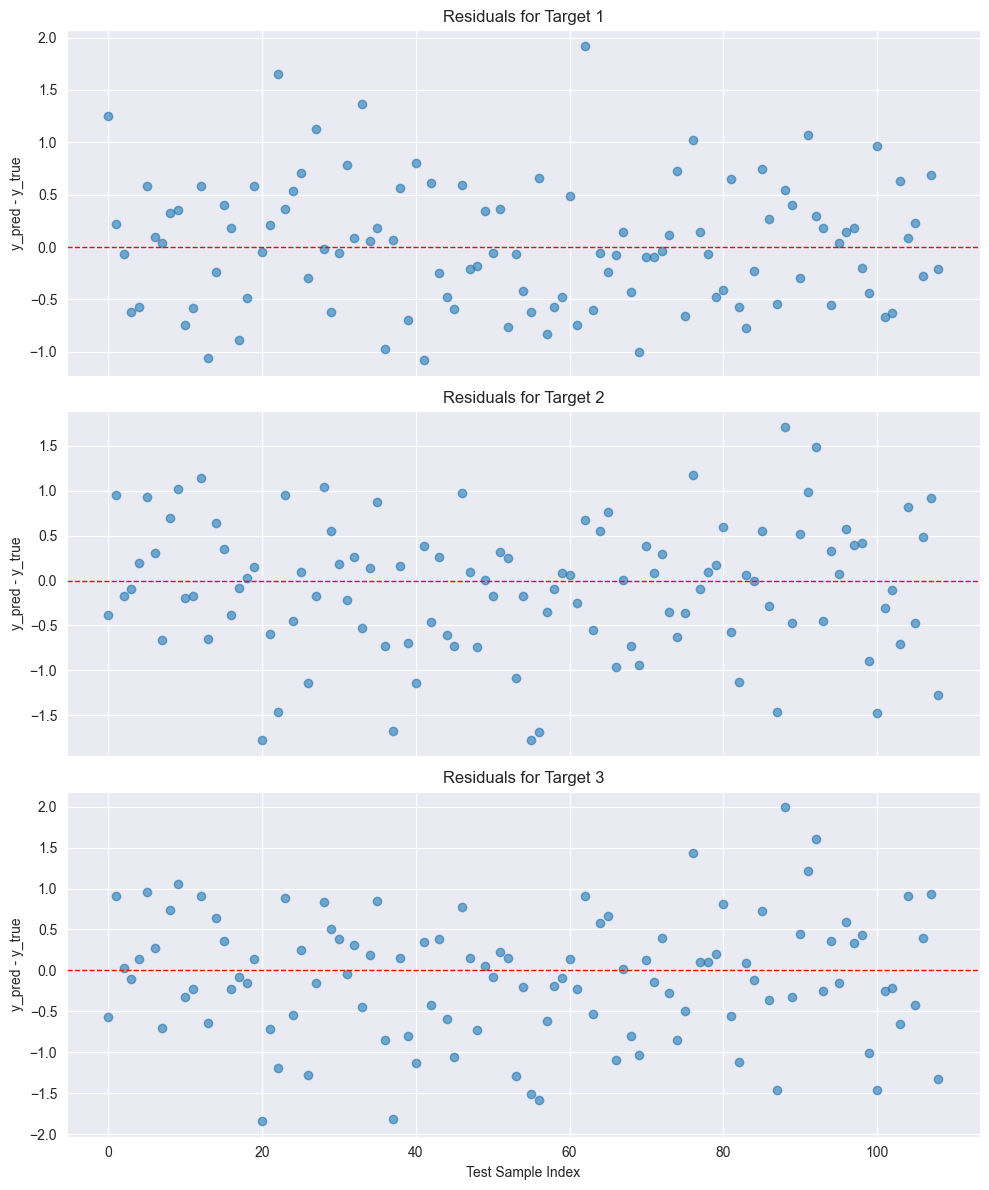

In [413]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

# y_true_np = y_test.cpu().numpy()
# y_pred_np = mean.cpu().numpy()
#
# num_targets = y_true_np.shape[1]

# Plot residuals for each target
fig, axs = plt.subplots(num_targets, 1, figsize=(10, 4 * num_targets), sharex=True)

for i in range(num_targets):
    residuals = y_pred_np[:, i] - y_true_np[:, i]

    axs[i].scatter(range(len(residuals)), residuals, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axs[i].set_title(f"Residuals for Target {i+1}")
    axs[i].set_ylabel("y_pred - y_true")
    axs[i].grid(True)

plt.xlabel("Test Sample Index")
plt.tight_layout()
plt.show()

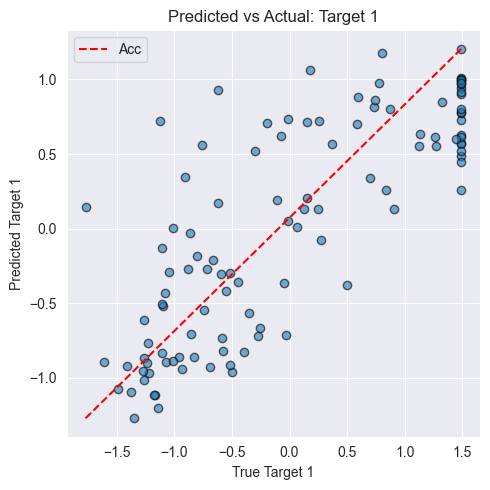

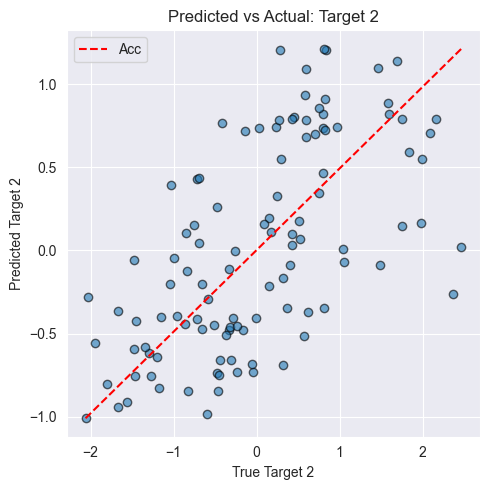

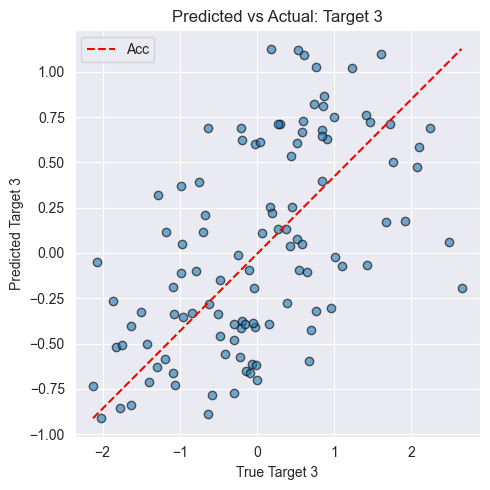

In [168]:
for i in range(y_test.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i].cpu().numpy(), mean[:, i].cpu().numpy(), alpha=0.6, edgecolors='k')
    plt.plot([y_test.cpu().numpy()[:, i].min(), y_test.cpu().numpy()[:, i].max()],
             [y_pred_np[:, i].min(), y_pred_np[:, i].max()], 'r--', label='Acc')

    plt.xlabel(f"True Target {i+1}")
    plt.ylabel(f"Predicted Target {i+1}")
    plt.title(f"Predicted vs Actual: Target {i+1}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# STL
## PTAU


In [425]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(alpha = 0.01, lengthscale = 0.02673124755002312), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [426]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 1) (109, 1)


In [427]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

In [336]:
def objective(trial):
    # Define hyperparameter search space
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    weight_decay = 1e-4
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    # scheduler_type = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealingLR"])

    # Model parameters
    lengthscale = trial.suggest_float("lengthscale", 1e-3, 1e1, log=True)
    outputscale = trial.suggest_float("outputscale", 0.1, 10.0, log=True)

    # Initialize likelihood for single task
    noise_prior = GammaPrior(concentration=1.1, rate=0.05)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior)

    # Single task GP model
    class SingleTaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(SingleTaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RQKernel(lengthscale=lengthscale),
                outputscale=outputscale
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # Reshape y_train for single task (squeeze to remove extra dimension)
    y_train_single = y_train.squeeze(-1)
    y_test_single = y_test.squeeze(-1)

    # Initialize model
    model = SingleTaskGPModel(X_train, y_train_single, likelihood)
    model.to(device)

    # Configure optimizer
    # if optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    # else:
    #     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)

    # Configure scheduler
    # if scheduler_type == "ReduceLROnPlateau":
    #     factor = trial.suggest_float("factor", 0.1, 0.9)
    #     patience = trial.suggest_int("patience", 3, 20)
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #         optimizer, mode='max', factor=factor, patience=patience, threshold=1e-4)
    # else:
    #     t_max = trial.suggest_int("t_max", 5, 50)
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    # Loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    initial_likelihood = mll(model(X_train), y_train_single)
    # while initial_likelihood < -3:
    #     model = SingleTaskGPModel(X_train, y_train_single, likelihood)
    #     model.to(device)
    #     initial_likelihood = mll(model(X_train), y_train_single)
    print(f'Model finally initialized with likelihood: {initial_likelihood}')


    # Train the model
    model.train()
    likelihood.train()

    num_iter = 500

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = mll(output, y_train_single)
        loss.backward()
        optimizer.step()

        # # Handle different scheduler types
        # if scheduler_type == "ReduceLROnPlateau":
        #     scheduler.step(loss.item())  # Pass validation metric
        # else:
        #     scheduler.step()

        # Report intermediate values for pruning
        if i % 20 == 0:
            trial.report(-loss.item(), i)

            # Enable pruning of unpromising trials
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Evaluate on test set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(X_test)
        mean = preds.mean

    y_true_np = y_test_single.cpu().numpy()
    y_pred_np = mean.cpu().numpy()

    # Calculate R² for single target
    r2 = r2_score(y_true_np, y_pred_np)

    return r2  # Return metric to maximize

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Best trial:")
trial = study.best_trial
print(f"  R² Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-02 16:13:24,074] A new study created in memory with name: no-name-7f730f44-5466-4e1f-8382-40395a96ca30


Model finally initialized with likelihood: -2.0260043144226074


[W 2025-07-02 16:13:26,516] Trial 0 failed with parameters: {'lr': 0.02454060566989365, 'optimizer': 'AdamW', 'lengthscale': 0.008703531697079214, 'outputscale': 0.3604639975307034} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Dhruv Khanna\AppData\Local\Temp\ipykernel_26204\1162631864.py", line 77, in objective
    loss = mll(output, y_train_single)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\module.py", line 82, in __call__
    outputs = self.forward(*inputs, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\mlls\exact_marginal_log_likelihood.py", 

KeyboardInterrupt: 

In [428]:
num_tasks = 1
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1)
likelihood.noise = 0.5
optimizer = torch.optim.AdamW(model.parameters(), lr=0.009910531762039601, weight_decay = 3.727074274208674e-05, maximize=True)
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
model.to(device)
initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -2.75:
    model = MultitaskGPModel(X_train, y_train, likelihood)
    model.to(device)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finally initialized with likelihood: {initial_likelihood}')
train_losses = []

RuntimeError: Shape mismatch: objects cannot be broadcast to a single shape

In [349]:
model.to(device)
model.train()
likelihood.train()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay = 1e-1, maximize=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.009969398049228019, weight_decay = 1e-4, maximize=True)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5639435252677821)

num_iter = 500
for i in range(num_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    train_losses.append(loss.item())

    # Break the loop if loss does not decrease significantly over the last 3 epochs
    if i > 3 and abs(train_losses[-1] - train_losses[-2]) < 1e-5 and abs(train_losses[-2] - train_losses[-3]) < 1e-5:
        print(f"Early stopping at iteration {i} with loss {loss.item()}")
        break

    loss.backward()
    optimizer.step()
    # scheduler.step(loss.item())
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/500 - Loss: -1.753
Iter 2/500 - Loss: -1.743
Iter 3/500 - Loss: -1.732
Iter 4/500 - Loss: -1.722
Iter 5/500 - Loss: -1.712
Iter 6/500 - Loss: -1.702
Iter 7/500 - Loss: -1.691
Iter 8/500 - Loss: -1.681
Iter 9/500 - Loss: -1.671
Iter 10/500 - Loss: -1.662
Iter 11/500 - Loss: -1.652
Iter 12/500 - Loss: -1.642
Iter 13/500 - Loss: -1.633
Iter 14/500 - Loss: -1.623
Iter 15/500 - Loss: -1.613
Iter 16/500 - Loss: -1.604
Iter 17/500 - Loss: -1.595
Iter 18/500 - Loss: -1.585
Iter 19/500 - Loss: -1.576
Iter 20/500 - Loss: -1.566
Iter 21/500 - Loss: -1.557
Iter 22/500 - Loss: -1.548
Iter 23/500 - Loss: -1.539
Iter 24/500 - Loss: -1.530
Iter 25/500 - Loss: -1.520
Iter 26/500 - Loss: -1.511
Iter 27/500 - Loss: -1.502
Iter 28/500 - Loss: -1.493
Iter 29/500 - Loss: -1.484
Iter 30/500 - Loss: -1.475
Iter 31/500 - Loss: -1.467
Iter 32/500 - Loss: -1.458
Iter 33/500 - Loss: -1.449
Iter 34/500 - Loss: -1.440
Iter 35/500 - Loss: -1.431
Iter 36/500 - Loss: -1.423
Iter 37/500 - Loss: -1.414
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

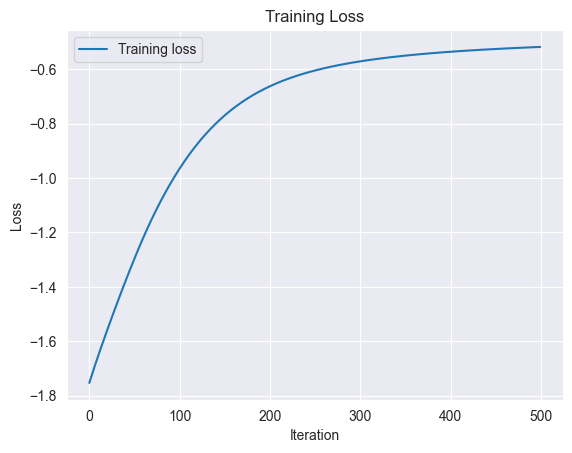

In [350]:
# Plot training loss
plt.title('Training Loss')
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [351]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.0037, RMSE = 0.0612, R2 = 0.9839


C:\Users\Dhruv Khanna\Documents\Coding stuff\ADML\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [352]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.cpu().numpy()
y_pred_np = mean.cpu().numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

Target 1: MSE = 0.1548, RMSE = 0.3934, R2 = 0.4224
